# Post-hoc statistics about generated results

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px


from paths import word_plot_res_path, word_plot_info_path, word_cluster_plot_path
from reshandler import EncoderResHandler
from measurements import *

## 1. Direction Consistency

In [2]:
vars = []
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()
    res = reshandler.data

    angles, var = DirectionalConsistency.analyze(res)
    vars.append(var)

In [3]:
np.mean(vars)

0.573041228383216

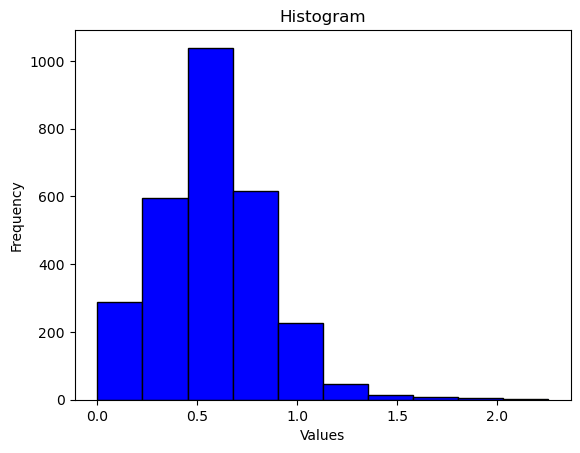

In [4]:
# Create a histogram
plt.hist(vars, bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


## 2. Clustering

### Looking for a good eps & min_samples using massive trials

In [5]:
num_clusters_list = []

for i in range(2000): 
    # Load your data (replace this with your own data)
    data = np.random.rand(20, 3)  # Example random data with shape (frame_num, 3)

    _, num_clusters = Clusterer.dbscan(data=data, r=0.36, m=1)

    num_clusters_list.append(num_clusters)

In [6]:
np.mean(num_clusters_list)

4.86

### Looping over the data

In [7]:
num_segments_list = []
num_clusters_list = []

file_prefixes = []
infos = []
labelss = []
ress = []

In [10]:
reshandler = EncoderResHandler(data_dir=word_plot_res_path, info_dir=word_plot_info_path)

for datapath in os.listdir(word_plot_res_path): 
    reshandler.file_prefix = datapath.split(".")[0]
    reshandler.read()

    res = reshandler.data
    info = reshandler.info

    labels, num_clusters = Clusterer.dbscan(res, r=0.25, m=1)

    file_prefixes.append(reshandler.file_prefix)
    num_segments_list.append(len(info[1].split(" ")))
    num_clusters_list.append(num_clusters)
    labelss.append(labels)

In [11]:
np.mean(num_segments_list), np.mean(num_clusters_list)

(3.954929577464789, 4.006690140845071)

In [12]:
# Create a DataFrame
df = pd.DataFrame({'Segments': num_segments_list, 'Clusters': num_clusters_list})

# Add a new column for the difference
df['Difference'] = df['Segments'] - df['Clusters']

In [13]:
df

,Segments,Clusters,Difference
0,3,5,-2
1,8,1,7
2,2,2,0
3,4,5,-1
4,5,4,1
...,...,...,...
5675,5,3,2
5676,4,3,1
5677,3,3,0
5678,2,4,-2


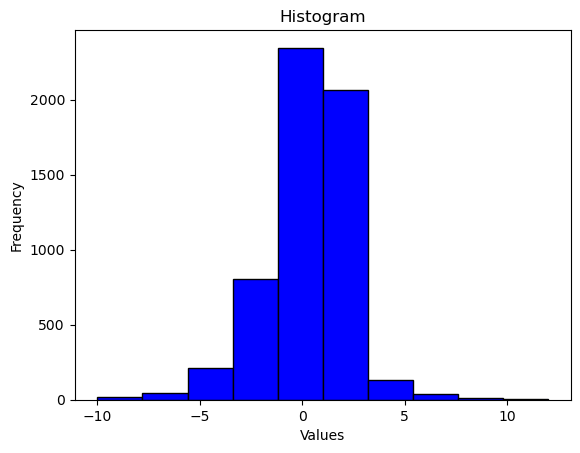

In [14]:
# Create a histogram
plt.hist(df['Difference'].tolist(), bins=10, color='blue', edgecolor='black')

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

### Plot the Clusters

In [15]:
def oneOut2ProgFrame(oneOut): 
    # oneOut is of tensor of shape (L, D)
    cols = ["dim_0", "dim_1", "dim_2", "cluster"]
    df = pd.DataFrame(oneOut, columns=cols)
    df["timestep"] = df.index
    df = df[["timestep"] + cols]
    return df
def minmax(arr, a=-1, b=1): 
    min = arr.min()
    max = arr.max()
    return (b - a) * ((arr - min) / (max - min)) + a
def operate_on(arr): 
    # return minmax(arr)
    return arr
def framify(these_hids): 
    # these are token categories to be included
    # these hids are the corresponding hids
    # these numtags are the corresponding tags, named using indices in these
    # these_hids = st.zscore(these_hids, axis=0)
    df = pd.DataFrame(data=these_hids)
    # df = df.rename(columns={0: "dim_0", 1: "dim_1", 2: "dim_2"})
    df['dim_0_norm'] = operate_on(df['dim_0'])
    df['dim_1_norm'] = operate_on(df['dim_1'])
    df['dim_2_norm'] = operate_on(df['dim_2'])
    return df

In [16]:
def plot3dtrajectory(X): 
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }

    fig = px.line_3d(framify(X), x="dim_0_norm", y="dim_1_norm", z="dim_2_norm", 
                     hover_data=["timestep"], color="cluster", markers=True)
    fig.update_traces(marker=dict(size=2, color="red"))
    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    # fig.update_layout(legend= {'itemsizing': 'constant'})
    # fig.update_layout(legend_title_text='Phone')
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

In [17]:
def save_html(htmlplot, file_name, info_token, info_produce_segs): 
    save_html_path = os.path.join(word_cluster_plot_path, "{}.html".format(file_name))
    with open(save_html_path, "w") as f: 
        f.write('<meta charset="UTF-8">')
        f.write("<h3>Token: {}</h3>".format(info_token))
        f.write("<h3>Produced Segments: {}</h3>".format(info_produce_segs))
        f.write("<hr>")
        f.write(htmlplot)

In [19]:
infos

[]

In [18]:
for idx in range(len(file_prefixes)): 
    file_name = file_prefixes[idx]
    info_token, info_produce_segs = infos[idx]
    res = ress[idx]
    labels = labelss[idx]

    # Convert the list to a NumPy array with shape (frame_num, 1)
    labels_array = np.array(labels).reshape(-1, 1)

    # Combine the arrays horizontally (horizontally stack them)
    combined_array = np.hstack((res, labels_array))

    html = plot3dtrajectory(combined_array)
    save_html(htmlplot=html, 
              file_name=file_name, 
              info_token=info_token, info_produce_segs=info_produce_segs)

IndexError: list index out of range